In [36]:
# 复现LDA主题模型
# 2022.09.05

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import os
project_path = os.getcwd()
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

import numpy as np
import pandas as pd
import time
import codecs
import jieba
import re

# LDA Topic Model - 1

In [ ]:
# github address: https://github.com/laserwave/topic_models/tree/master/LDA-demo

## data_process

In [32]:
# 预处理(分词，去停用词，为每个word赋予一个编号，文档使用word编号的列表表示)
def preprocessing():
    # 读取停用词文件
    file = codecs.open('./data/lda_data/stopwords.dic', 'r', 'utf-8')
    stopwords = [line.strip() for line in file]
#     print(stopwords)
    file.close()
    
    # 读数据集
    file = codecs.open('./data/lda_data/dataset_cn.txt', 'r', 'utf-8')
    documents = [document.strip() for document in file]
    file.close()
    
    word2id = {}
    id2word = {}
    docs = []
    currentDocument = []
    currentWordId = 0
    
    # 将word转换为word编号
    for document in documents:
        # 分词
        segList = jieba.cut(document)
        for word in segList:
            word = word.lower().strip()
            # 单词长度大于1并且不包含数字和停用词
            if len(word) > 1 and not re.match('[0-9]', word) and word not in stopwords:
                if word in word2id:
                    currentDocument.append(word2id[word])
                else:
                    currentDocument.append(currentWordId)
                    word2id[word] = currentWordId
                    id2word[currentWordId] = word
                    currentWordId += 1
        docs.append(currentDocument)
        currentDocument = []
    return docs, word2id, id2word

## Initialize

In [20]:
# 初始化，按照每个topic概率都相等的multinomial分布采样，等价于取随机数，并更新采样出topic的相关计数
def randomInitialize():
    for d,doc in enumerate(docs):
        zCurrentDoc = []
        for w in doc:
            pz = np.divide(np.multiply(ndz[d,:], nzw[:,w]), nz)
            z = np.random.multinomial(1, pz/pz.sum()).argmax()
            zCurrentDoc.append(z)
            ndz[d, z] += 1
            nzw[z, w] += 1
            nz[z] += 1
        Z.append(zCurrentDoc)

## Gibbs Sampling

In [29]:
def gibbsSampling():
    # 为每个文档中的每个单词重新采样topic
    for d, doc in enumerate(docs):
        for index, w in enumerate(doc):
            z = Z[d][index]
            # 将当前文档当前单词原topic相关计数减去1
            ndz[d, z] -= 1
            nzw[z, w] -= 1
            nz[z] -= 1
            # 重新计算当前文档当前单词属于每个topic的概率
            pz = np.divide(np.multiply(ndz[d, :], nzw[:, w]), nz)
            # 按照计算出的分布进行采样
            z = np.random.multinomial(1, pz/pz.sum()).argmax()
            Z[d][index] = z
            # 将当前文档当前单词新采样的topic相关计数加上1
            ndz[d, z] += 1
            nzw[z, w] += 1
            nz[z] += 1

## perplexity

In [24]:
def perplexity():
    nd = np.sum(ndz, 1)
    n = 0
    ll = 0.0
    for d, doc in enumerate(docs):
        for w in doc:
            ll = ll + np.log(((nzw[:,w] /nz) * (ndz[d,:]/nd[d])).sum())
            n += 1
    return np.exp(ll/(-n))

## main函数

In [31]:
np.divide([1,2,4],4)

array([0.25, 0.5 , 1.  ])

In [33]:
alpha = 5
beta = 0.1
iterationNum = 50
Z = []
K = 10
docs, word2id, id2word = preprocessing()
N = len(docs)
M = len(word2id)
ndz = np.zeros([N, K]) +alpha
nzw = np.zeros([K, M]) + beta
nz = np.zeros([K]) + M *beta
randomInitialize()
for i in range(0, iterationNum):
    gibbsSampling()
    print(time.strftime('%X'), "Iteration: ", i, "Completed", "Perplexity: ", perplexity())

topicwords = []
maxTopicWordsNum = 10
for z in range(0, K):
    ids = nzw[z, :].argsort()
    topicword = []
    for j in ids:
        topicword.insert(0, id2word[j])
        topicwords.append(topicword[0 : min(10, len(topicword))])

16:39:09 Iteration:  0 Completed Perplexity:  11582.146895703156
16:39:50 Iteration:  1 Completed Perplexity:  11339.928293864568
16:40:31 Iteration:  2 Completed Perplexity:  11088.663240092887
16:41:12 Iteration:  3 Completed Perplexity:  10827.393057423567
16:41:54 Iteration:  4 Completed Perplexity:  10564.5878706307
16:42:36 Iteration:  5 Completed Perplexity:  10302.244933233324
16:43:16 Iteration:  6 Completed Perplexity:  10044.952819077775
16:43:54 Iteration:  7 Completed Perplexity:  9800.143381392496
16:44:33 Iteration:  8 Completed Perplexity:  9575.574499777336
16:45:15 Iteration:  9 Completed Perplexity:  9373.04215127336
16:45:58 Iteration:  10 Completed Perplexity:  9189.507461441235
16:46:40 Iteration:  11 Completed Perplexity:  9023.712437190741
16:47:21 Iteration:  12 Completed Perplexity:  8875.503273681588
16:48:01 Iteration:  13 Completed Perplexity:  8740.592365535646
16:48:43 Iteration:  14 Completed Perplexity:  8613.339071966422
16:49:24 Iteration:  15 Complet

# LDA topic model - 2

In [35]:
# 利用gensim训练LDA主题模型，进行新闻文本主题分析
# github address: git@github.com:DengYangyong/LDA_gensim.git

In [36]:
import jieba, os, re
from gensim import corpora, models, similarities

## 创建停用词表

In [73]:
def stopwordlist():
    file = open('./data/lda_data/gensim_data/stopwords.txt', encoding='utf-8')
    stopwords = [line.strip() for line in file.readlines()]
    return stopwords

## 中文分词

In [41]:
def segSentence(sentence):
    sentence_depart = jieba.cut(sentence.strip())
    stopwords = stopwordlist()
    outstr = ''
    for word in sentence_depart:
        if word not in stopwords:
            outstr += word
            outstr += ' '
    return outstr

In [44]:
# 如果文档还没分词，就先进行分词
if not os.path.exists('./data/lda_data/gensim_data/cnews.train_jieba.txt'):
    # 给出文档路径
    filename = "./data/lda_data/gensim_data/cnews.train.txt"
    outfilename = "./data/lda_data/gensim_data/cnews.train_jieba.txt"
    inputs = open(filename, 'r', encoding='utf-8')
    outputs = open(outfilename, 'w', encoding='utf-8')
    # 把非汉字的字符全部去掉
    # 将输出结果写入outputs中
    for line in inputs:
        line = line.split('\t')[1]
        line = re.sub(r'[^\u4e00-\u9fa5]+', '', line) # 非中文字符去掉
        line_seg = segSentence(line.strip())
        outputs.write(line_seg.strip() + '\n')
    
    outputs.close()
    inputs.close()
    print('删除停用词和分词成功')

## train_data_process

In [54]:
# 准备好训练语料，整理成gensim需要的输入格式
fr = open('./data/lda_data/gensim_data/cnews.train_jieba.txt', 'r', encoding='utf-8')
train = []
for line in fr.readlines():
    line = [word.strip() for word in line.split(' ')]
    print(line)
    train.append(line)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




['入门', '强势', '展现', '索尼', '单反', '仅售元', '云南', '帮', '最新', '最新', '影像', '传感器', '影像', '处理器', '搭配', '镜头', '款', '索尼', '带来', '细腻', '画质', '外观', '索尼', '整体', '外形尺寸', '为重', '约', '机身', '采用', '工程塑料', '外壳', '金属', '构架', '设计', '外壳', '大面积', '蒙皮', '弥补', '塑料', '手感', '镜头', '款', '索尼', '索尼', '数码影像', '三大', '核心技术', '影像', '传感器', '影像', '处理器', '卡尔蔡', '司', '镜头', '镜头', '最佳', '融合', '画质', '优势', '体现', '全新', '万', '像素', '影像', '传感器', '全新', '影像', '处理器', '带来', '可达', '细腻', '画面', '屏幕', '采用', '一块', '英寸', '万', '像素', '折叠', '液晶屏', '度', '翻转', '有助于', '角度', '取景', '配合', '自动', '对焦', '实时', '取景', '功能', '功能', '索尼', '开创性', '速度', '优先', '连续', '模式', '高速', '拍', '能力', '每秒', '约', '张为', '系统', '入门级', '用户', '带来', '专业级', '拍摄', '体验', '首次', '入门', '机型', '全新', '全新', '影像', '处理器', '更少', '噪', '点将', '以往', '清晰', '拍摄', '场景', '清晰', '凝固', '相机', '里', '细腻', '图像', '表现', '拓展', '数码', '摄影', '拍摄', '扩展', '索尼', '配备', '自动', '高', '动态', '功能', '带来', '动态', '拓展', '记录', '下大光', '情况', '下高光', '阴影', '真实', '细节', '带来', '层次感', '细腻', '色彩', '表现', '适合', '表现', '日落', '城市', '风光', '在内', '

In [55]:
# 构建词频矩阵，训练LDA模型
dictionary = corpora.Dictionary(train)
# corpus是把每条新闻id化后的结果，每个元素是新闻中的每个词语，在字典中的id和频率
corpus = [dictionary.doc2bow(text) for text in train]

In [65]:
lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)

In [63]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 2),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 2),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 2),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 5),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 2),
 (32, 1),
 (33, 4),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 2),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 2),
 (47, 1),
 (48, 3),
 (49, 1)]

In [66]:
topic_list = lda.print_topics(10)
print('10个主题的单词分布为:\n')
for topic in topic_list:
    print(topic)

10个主题的单词分布为:

(0, '0.008*"中" + 0.007*"功能" + 0.006*"时尚" + 0.005*"搭配" + 0.005*"拍摄" + 0.004*"设计" + 0.004*"英语" + 0.004*"采用" + 0.003*"镜头" + 0.003*"小巧"')
(1, '0.035*"机身" + 0.006*"感应器" + 0.005*"中" + 0.005*"万" + 0.004*"拍摄" + 0.004*"比赛" + 0.003*"元" + 0.003*"高清" + 0.002*"说" + 0.002*"采用"')
(2, '0.004*"中国" + 0.004*"中" + 0.004*"信息" + 0.003*"新浪" + 0.003*"市场" + 0.003*"说" + 0.002*"企业" + 0.002*"托管" + 0.002*"全景网" + 0.002*"上证"')
(3, '0.009*"拍摄" + 0.009*"功能" + 0.008*"玩家" + 0.006*"设计" + 0.006*"视频" + 0.006*"支持" + 0.006*"中" + 0.005*"活动" + 0.005*"元" + 0.004*"高清"')
(4, '0.034*"基金" + 0.012*"市场" + 0.011*"投资" + 0.009*"中" + 0.008*"公司" + 0.008*"分红" + 0.006*"股票" + 0.005*"经济" + 0.005*"新" + 0.005*"中国"')
(5, '0.032*"考试" + 0.009*"中" + 0.006*"发展" + 0.005*"活动" + 0.004*"新能源" + 0.004*"阅读" + 0.003*"说" + 0.003*"工作" + 0.003*"经济" + 0.003*"行业"')
(6, '0.101*"基金" + 0.015*"公司" + 0.007*"中" + 0.006*"股票" + 0.005*"相机" + 0.005*"投资" + 0.005*"市场" + 0.005*"经理" + 0.005*"管理" + 0.004*"亿元"')
(7, '0.035*"基金" + 0.010*"中" + 0.009*"赎回" + 0.009*"市场

## test

In [83]:
# 抽取新闻主题
file_test = './data/lda_data/gensim_data/cnews.test.txt'
news_test = open(file_test, 'r', encoding='utf-8')

In [84]:
test=[]
# 将text文本处理成正确的输入格式
for line in news_test:
    line = line.split('\t')[1]
#     print(line)
    line = re.sub(r'[^\u4e00-\u9fa5]+', '', line)
    line_seg = segSentence(line.strip())
    line_seg = [word.strip() for word in line_seg.split(' ')]
    test.append(line_seg)

In [85]:
# 新闻id化
corpus_test = [dictionary.doc2bow(text) for text in test]

In [91]:
# 得到每条新闻的主题分布
topics_test = lda.get_document_topics(corpus_test)

In [92]:
topics_test

In [93]:
labels = ['体育','娱乐','科技','时尚','房产','科技','财经']

In [95]:
for i in range(len(topics_test)):
    print('这条'+labels[i]+'新闻的主题分布为：\n')
    print(topics_test[i], '\n')
fr.close()
news_test.close()

这条体育新闻的主题分布为：

[(0, 0.35282445), (1, 0.31178406), (2, 0.061604854), (4, 0.21195798), (9, 0.058855895)] 

这条娱乐新闻的主题分布为：

[(0, 0.52870804), (3, 0.18823624), (4, 0.07397453), (5, 0.08521199), (6, 0.12118237)] 

这条科技新闻的主题分布为：

[(3, 0.25333044), (4, 0.39492148), (6, 0.029376602), (7, 0.25516754), (8, 0.06443821)] 

这条时尚新闻的主题分布为：

[(0, 0.7996573), (4, 0.17725848)] 

这条房产新闻的主题分布为：

[(2, 0.391524), (4, 0.60288227)] 

这条科技新闻的主题分布为：

[(1, 0.023302888), (3, 0.20670833), (8, 0.7583779)] 

这条财经新闻的主题分布为：

[(4, 0.845487), (7, 0.1511024)] 



# lda2vec

In [97]:
# github address: https://github.com/cemoody/lda2vec

In [98]:
'''
topic vector is similar to its word vectors
document vector is a weighted sum of topic vectors.
The lda2vec model tries to mix the best parts of word2vec and LDA into a single framework. 
    word2vec captures powerful relationships between words, 
        but the resulting vectors are largely uninterpretable and don't represent documents. 
    LDA on the other hand is quite interpretable by humans, 
        but doesn't model local word relationships like word2vec. 
We build a model that builds both word and document topics, makes them interpreable, makes topics over clients, times, and documents, and makes them supervised topics.
'''

'\ntopic vector is similar to its word vectors\ndocument vector is a weighted sum of topic vectors.\n'

## dirichlet likelihood

In [101]:
# 参数为α的Dirichlet分布随机生成主题分布θ
# 参数为β的Dirichlet分布随机生成词语分布Ф

In [103]:
import chainer.functions as F
from chainer import Variableable

In [104]:
def dirichlet_likelihood(weights, alpha=None):
    '''
    Calculate the log likelihood of the observed topic proportions.
    A negative likelihood is more likely than a negative likelihood.
    Args:
        weights(Chainer.Variable): Unnormalized weight vector.
            The vector will be passed through a softmax function that will map the input onto a probability simplex.
        alpha(float): The Dirichlet concentration parameter.
            Alpha greater than 1.0 results in very dense topic weights such that each document belongs to many topics.
            Alpha < 1.0 results in sparser topic weights.
            The default is to set alpha to 1.0/n_topics
    Returns:
        ~chainer.Variable: Output loss variable.
    '''
    if type(ewights) is Variable:
        n_topics = weights.data.shape[1]
    else:
        n_topics = weights.W.data.shape[1]
    
    if alpha is None:
        alpha = 1.0/n_topics
    
    if type(weights) is Variable:
        log_proportions = F.log_softmax(weights)
    else:
        log_proportions = F.log_softmax(weights.W)
    
    loss = (alpha - 1.0) * log_proportions
    return -F.sum(loss)

## embed_mixture

In [106]:
import numpy as np

import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Variable

In [107]:
def _orthogonal_matrix(shape):
    # stolen from blocks
    # github.com/mila-udem/blocks/blob/master/blocks/initialization.py
    M1 = np.random.randn(shape[0], shape[0])
    M2 = np.random.randn(shape[1], shape[1])
    
    # QR decomposition of matrix with entries in N(0,1) is random
    Q1, R1 = np.linalg.qr(M1)
    Q2, R2 = np.linalg.qr(M2)
    
    # correct that numpy doesn't force diagnoal of R to be non-negative
    Q1 = Q1 * np.sign(np.diag(R1))
    Q2 = Q2 * np.sign(np.diag(R2))
    
    n_min = min(shape[0], shape[1])
    return np.dot(Q1[:,:n_min], Q2[:n_min,:])

In [108]:
class EmbedMixture(chainer.Chain):
    r""" A single document is encoded as a multinomial mixture of latent topics.
    The mixture is defined on simplex, so that mixture weights always sum
    to 100%. The latent topic vectors resemble word vectors whose elements are
    defined over all real numbers.
    For example, a single document mix may be :math:`[0.9, 0.1]`, indicating
    that it is 90% in the first topic, 10% in the second. An example topic
    vector looks like :math:`[1.5e1, -1.3e0, +3.4e0, -0.2e0]`, which is
    largely uninterpretable until you measure the words most similar to this
    topic vector.
    A single document vector :math:`\vec{e}` is composed as weights :math:`c_j`
    over topic vectors :math:`\vec{T_j}`:
    .. math::
        \vec{e}=\Sigma_{j=0}^{j=n\_topics}c_j\vec{T_j}
    This is usually paired with regularization on the weights :math:`c_j`.
    If using a Dirichlet prior with low alpha, these weights will be sparse.
    Args:
        n_documents (int): Total number of documents
        n_topics (int): Number of topics per document
        n_dim (int): Number of dimensions per topic vector (should match word
            vector size)
    Attributes:
        weights : chainer.links.EmbedID
            Unnormalized topic weights (:math:`c_j`). To normalize these
            weights, use `F.softmax(weights)`.
        factors : chainer.links.Parameter
            Topic vector matrix (:math:`T_j`)
    .. seealso:: :func:`lda2vec.dirichlet_likelihood`
    """
    def __init__(self, n_documents, n_topics, n_dim, dropout_ratio=0.2, temperature =1.0):
        self.n_documents = n_documents
        self.n_topics = n_topics
        self.n_dim = n_dim
        self.dropout_ratio = dropout_ratio
        factors = _orthogonal_matrix((n_topics, n_dim)).astype('float32')
        factors /= np.sqrt(n_topics + n_dim)
        super(EmbedMixture, self).__init__(
            weights=L.EmbedID(n_documents, n_topics),
            factors=L.Parameter(factors))
        self.temperature = temperature
        self.weights.W.data[...] /= np.sqrt(n_documents + n_topics)
        
    def __cal__(self, doc_ids, update_only_docs=False):
        '''
        Given an array of document integer indices, returns a vector for each document.
        The vector is composed of topic weights projected onto topic vectors.
        Args:
            doc_ids : chainer.Variable
                One-dimensional batch vectors of IDs
        Returns:
            doc_vector : chainer.Variable
                Batch of two-dimensional embeddings for every document.
        '''
        # (batchsize,) --> (batchsize, multinomial)
        proportions = self.proportions(doc_ids, softmax=True)
        # (batchsize, n_factors) * (n_factors, n_dim) --> (batchsize, n_dim)
        factors = F.dropout(self.factors(), ratio=self.dropout_ratio)
        if update_only_docs:
            factors.unchain_backward()
        w_sum = F.matmul(proportions, factors)
        return w_sum
    
    def proportions(self, doc_ids, softmax=False):
        '''
        Given an array of document indices, return a vector
        for each document of just the unnormalized topic weights.
        Returns:
            doc_weights : chainer.Variable
                Two dimensional topic weights of each document.
        '''
        w = self.weights(doc_ids)
        if softmax:
            size = w.data.shape
            mask = self.xp.random.random_integers(0,1,size=size)
            y = (F.softmax(w * self.temperature) * 
                Variable(mask.astype('float32')))
            norm, y = F.broadcast(F.expand_dims(F.sum(y, axis=1), 1), y)
            return y/(norm + 1e-7)
        else:
            return w

## tracking

In [110]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [126]:
class Tracking:
    cache = {}
    calls = 0
    slope = 0.0
    
    def __init__(self, n=5000):
        '''
        """ The tracking class keeps a most recently used cache of values
        Parameters
        ----------
        n: int
        Number of items to keep.
        '''
        self.n = n
    
    def add(self, key, item):
        if key not in self.cashe:
            self.cache[key] = []
        self.cache[key].append(item)
        if len(self.cache[key]) > self.n:
            self.cache[key] = self.cache[key][:self.n]
    
    def status(self, key):
        '''
        Get the statistics for items with a particular key
        tracker = Tracking()
        tracker.add('log_perplexity', 55.6)
        tracker.add('log_perplexity', 55.2)
        tracker.stats('log_perplexity')
        (55.400000000000006, 0.19999999999999929, 0.0)
        '''
        data = self.cache[key]
        mean = np.mean(data)
        std = np.std(data)
        slope = self.slope
        if self.calls % 100 ==0:
            lr = LinearRegression()
            x = np.arrang(len(data)).astype('float32')
            lr.fit(x[:,None], np.array(data))
            self.slope = lr.coef_[0]
        self.calls += 1
        return mean, std, slope
    

In [127]:
    if __name__ == '__main__':
        import doctest
        doctest.testmod()

## preprocess

In [132]:
from spacy.lang.en import English
from spacy.attrs import LOWER, LIKE_URL, LIKE_EMAIL

import numpy as np

In [136]:
def tokenize(texts, max_length, skip=-2, attr=LOWER, merge=False, nlp=None, **kwargs):
    if nlp is None:
        nlp = English()
    data = np.zeros((len(texts), max_length), dtype='int32')
    data[:] = skip
    bad_deps = ('amod', 'compound')
    for row, doc in enumerate(nlp.pipe(texts, **kwargs)):
        if merge:
            # from the spaCy blog, an example on how to merge
            # noun phrases into single tokens
            for phrase in doc.noun_chunks:
                # Only keep adjectives and nouns, e.g. "good ideas"
                while len(phrase) > 1 and phrase[0].dep_ not in bad_deps:
                    phrase = phrase[1:]
                if len(phrase) > 1:
                    # Merge the tokens, e.g. good_ideas
                    phrase.merge(phrase.root.tag_, phrase.text,
                                 phrase.root.ent_type_)
                # Iterate over named entities
                for ent in doc.ents:
                    if len(ent) > 1:
                        # Merge them into single tokens
                        ent.merge(ent.root.tag_, ent.text, ent.label_)
        dat = doc.to_array([attr, LIKE_EMAIL, LIKE_URL]).astype('int32')
        if len(dat) > 0:
            dat = dat.astype('int32')
            msg = "Negative indices reserved for special tokens"
            assert dat.min() >= 0, msg
            # Replace email and URL tokens
            idx = (dat[:, 1] > 0) | (dat[:, 2] > 0)
            dat[idx] = skip
            length = min(len(dat), max_length)
            data[row, :length] = dat[:length, 0].ravel()
    uniques = np.unique(data)
    vocab = {v: nlp.vocab[v].lower_ for v in uniques if v != skip}
    vocab[skip] = '<SKIP>'
    return data, vocab

In [137]:
if __name__ == "__main__":
    import doctest
    doctest.testmod()

## corpus

In [142]:
from collections import defaultdict
import numpy as np
import difflib
import pandas as pd

try:
    from pyxdameraulevenshtein import damerau_levenshtein_distance_withNPArray
except ImportError:
    pass

In [144]:
class Corpus():
    _keys_frequency = None

    def __init__(self, out_of_vocabulary=-1, skip=-2):
        
        self.counts_loose = defaultdict(int)
        self._finalized = False
        self.specials = dict(out_of_vocabulary=out_of_vocabulary,
                             skip=skip)

    @property
    def n_specials(self):
        return len(self.specials)

    def update_word_count(self, loose_array):
        """ Update the corpus word counts given a loose array of word indices.
        Can be called multiple times, but once `finalize` is called the word
        counts cannot be updated.
        Arguments
        ---------
        loose_array : int array
            Array of word indices.
        Examples
        --------
        >>> corpus = Corpus()
        >>> corpus.update_word_count(np.arange(10))
        >>> corpus.update_word_count(np.arange(8))
        >>> corpus.counts_loose[0]
        2
        >>> corpus.counts_loose[9]
        1
        """
        self._check_unfinalized()
        uniques, counts = np.unique(np.ravel(loose_array), return_counts=True)
        msg = "Loose arrays cannot have elements below the values of special "
        msg += "tokens as these indices are reserved"
        assert uniques.min() >= min(self.specials.values()), msg
        for k, v in zip(uniques, counts):
            self.counts_loose[k] += v

    def _loose_keys_ordered(self):
        """ Get the loose keys in order of decreasing frequency"""
        loose_counts = sorted(self.counts_loose.items(), key=lambda x: x[1],
                              reverse=True)
        keys = np.array(loose_counts)[:, 0]
        counts = np.array(loose_counts)[:, 1]
        order = np.argsort(counts)[::-1].astype('int32')
        keys, counts = keys[order], counts[order]
        # Add in the specials as a prefix to the other keys
        specials = np.sort(self.specials.values())
        keys = np.concatenate((specials, keys))
        empty = np.zeros(len(specials), dtype='int32')
        counts = np.concatenate((empty, counts))
        n_keys = keys.shape[0]
        assert counts.min() >= 0
        return keys, counts, n_keys

    def finalize(self):
       
        # Return the loose keys and counts in descending count order
        # so that the counts arrays is already in compact order
        self.keys_loose, self.keys_counts, n_keys = self._loose_keys_ordered()
        self.keys_compact = np.arange(n_keys).astype('int32')
        self.loose_to_compact = {l: c for l, c in
                                 zip(self.keys_loose, self.keys_compact)}
        self.compact_to_loose = {c: l for l, c in
                                 self.loose_to_compact.items()}
        self.specials_to_compact = {s: self.loose_to_compact[i]
                                    for s, i in self.specials.items()}
        self.compact_to_special = {c: s for c, s in
                                   self.specials_to_compact.items()}
        self._finalized = True

    @property
    def keys_frequency(self):
        if self._keys_frequency is None:
            f = self.keys_counts * 1.0 / np.sum(self.keys_counts)
            self._keys_frequency = f
        return self._keys_frequency

    def _check_finalized(self):
        msg = "self.finalized() must be called before any other array ops"
        assert self._finalized, msg

    def _check_unfinalized(self):
        msg = "Cannot update word counts after self.finalized()"
        msg += "has been called"
        assert not self._finalized, msg

    def filter_count(self, words_compact, min_count=15, max_count=0,
                     max_replacement=None, min_replacement=None):
        
        self._check_finalized()
        ret = words_compact.copy()
        if min_replacement is None:
            min_replacement = self.specials_to_compact['out_of_vocabulary']
        if max_replacement is None:
            max_replacement = self.specials_to_compact['out_of_vocabulary']
        not_specials = np.ones(self.keys_counts.shape[0], dtype='bool')
        not_specials[:self.n_specials] = False
        if min_count:
            # Find first index with count less than min_count
            min_idx = np.argmax(not_specials & (self.keys_counts < min_count))
            # Replace all indices greater than min_idx
            ret[ret > min_idx] = min_replacement
        if max_count:
            # Find first index with count less than max_count
            max_idx = np.argmax(not_specials & (self.keys_counts < max_count))
            # Replace all indices less than max_idx
            ret[ret < max_idx] = max_replacement
        return ret

    def subsample_frequent(self, words_compact, threshold=1e-5):
       
        self._check_finalized()
        freq = self.keys_frequency + 1e-10
        pw = 1.0 - (np.sqrt(threshold / freq) + threshold / freq)
        prob = fast_replace(words_compact, self.keys_compact, pw)
        draw = np.random.uniform(size=prob.shape)
        ret = words_compact.copy()
        # If probability greater than draw, skip the word
        ret[prob > draw] = self.specials_to_compact['skip']
        return ret

    def to_compact(self, word_loose):
        
        self._check_finalized()
        keys = self.keys_loose
        reps = self.keys_compact
        uniques = np.unique(word_loose)
        # Find the out of vocab indices
        oov = np.setdiff1d(uniques, keys, assume_unique=True)
        oov_token = self.specials_to_compact['out_of_vocabulary']
        keys = np.concatenate((keys, oov))
        reps = np.concatenate((reps, np.zeros_like(oov) + oov_token))
        compact = fast_replace(word_loose, keys, reps)
        msg = "Error: all compact indices should be non-negative"
        assert compact.min() >= 0, msg
        return compact

    def to_loose(self, word_compact):    
        self._check_finalized()
        uniques = np.unique(word_compact)
        # Find the out of vocab indices
        oov = np.setdiff1d(uniques, self.keys_compact, assume_unique=True)
        msg = "Found keys in `word_compact` not present in the"
        msg += "training corpus. Is this actually a compacted array?"
        assert np.all(oov < 0), msg
        loose = fast_replace(word_compact, self.keys_compact, self.keys_loose)
        return loose

    def compact_to_flat(self, word_compact, *components):
        
        self._check_finalized()
        n_docs = word_compact.shape[0]
        max_length = word_compact.shape[1]
        idx = word_compact > self.n_specials
        components_raveled = []
        msg = "Length of each component must much `word_compact` size"
        for component in components:
            raveled = np.tile(component[:, None], max_length)[idx]
            components_raveled.append(raveled)
            assert len(component) == n_docs, msg
        if len(components_raveled) == 0:
            return word_compact[idx]
        else:
            return word_compact[idx], components_raveled

    def word_list(self, vocab, max_compact_index=None, oov_token='<OoV>'):
        
        # Translate the compact keys into string words
        oov = self.specials['out_of_vocabulary']
        words = []
        if max_compact_index is None:
            max_compact_index = self.keys_compact.shape[0]
        index_to_special = {i: s for s, i in self.specials.items()}
        for compact_index in range(max_compact_index):
            loose_index = self.compact_to_loose.get(compact_index, oov)
            special = index_to_special.get(loose_index, oov_token)
            string = vocab.get(loose_index, special)
            words.append(string)
        return words

    def compact_word_vectors(self, vocab, filename=None, array=None,
                             top=20000):
       
        n_words = len(self.compact_to_loose)
        from gensim.models.word2vec import Word2Vec
        model = Word2Vec.load_word2vec_format(filename, binary=True)
        n_dim = model.syn0.shape[1]
        data = np.random.normal(size=(n_words, n_dim)).astype('float32')
        data -= data.mean()
        data += model.syn0.mean()
        data /= data.std()
        data *= model.syn0.std()
        if array is not None:
            data = array
            n_words = data.shape[0]
        keys_raw = model.vocab.keys()
        keys = [s.encode('ascii', 'ignore') for s in keys_raw]
        lens = [len(s) for s in model.vocab.keys()]
        choices = np.array(keys, dtype='S')
        lengths = np.array(lens, dtype='int32')
        s, f = 0, 0
        rep0 = lambda w: w
        rep1 = lambda w: w.replace(' ', '_')
        rep2 = lambda w: w.title().replace(' ', '_')
        reps = [rep0, rep1, rep2]
        for compact in np.arange(top):
            loose = self.compact_to_loose.get(compact, None)
            if loose is None:
                continue
            word = vocab.get(loose, None)
            if word is None:
                continue
            word = word.strip()
            vector = None
            for rep in reps:
                clean = rep(word)
                if clean in model.vocab:
                    vector = model[clean]
                    break
            if vector is None:
                try:
                    word = unicode(word)
                    idx = lengths >= len(word) - 3
                    idx &= lengths <= len(word) + 3
                    sel = choices[idx]
                    d = damerau_levenshtein_distance_withNPArray(word, sel)
                    choice = np.array(keys_raw)[idx][np.argmin(d)]
                    # choice = difflib.get_close_matches(word, choices)[0]
                    vector = model[choice]
                    print(compact, word, ' --> ', choice)
                except IndexError:
                    pass
            if vector is None:
                f += 1
                continue
            s += 1
            data[compact, :] = vector[:]
        return data, s, f

    def compact_to_bow(self, word_compact, max_compact_index=None):
        
        if max_compact_index is None:
            max_compact_index = word_compact.max()

        def bincount(x):
            return np.bincount(x, minlength=max_compact_index + 1)
        axis = len(word_compact.shape) - 1
        bow = np.apply_along_axis(bincount, axis, word_compact)
        return bow

    def compact_to_coocurrence(self, word_compact, indices, window_size=10):
        
        tokens = pd.DataFrame(dict(word_index=word_compact)).reset_index()
        for name, index in indices.items():
            tokens[name] = index
        a, b = tokens.copy(), tokens.copy()
        mask = lambda x: np.prod([x[k + '_x'] == x[k + '_y']
                                  for k in indices.keys()], axis=0)
        group_keys = ['word_index_x', 'word_index_y', ]
        group_keys += [k + '_x' for k in indices.keys()]
        total = []
        a['frame'] = a['index'].copy()
        for frame in range(-window_size, window_size + 1):
            if frame == 0:
                continue
            b['frame'] = b['index'] + frame
            matches = (a.merge(b, on='frame')
                        .assign(same_doc=mask)
                        .pipe(lambda df: df[df['same_doc'] == 1])
                        .groupby(group_keys)['frame']
                        .count()
                        .reset_index())
            total.append(matches)
        counts = (pd.concat(total)
                    .groupby(group_keys)['frame']
                    .sum()
                    .reset_index()
                    .rename(columns={k + '_x': k for k in indices.keys()})
                    .rename(columns=dict(frame='counts')))
        return counts

In [145]:
def fast_replace(data, keys, values, skip_checks=False):
    
    assert np.allclose(keys.shape, values.shape)
    if not skip_checks:
        msg = "data has elements not in keys"
        assert data.max() <= keys.max(), msg
    sdx = np.argsort(keys)
    keys, values = keys[sdx], values[sdx]
    idx = np.digitize(data, keys, right=True)
    new_data = values[idx]
    return new_data

## topics

In [149]:
import numpy as np
import requests
import multiprocessing

In [150]:
def _softmax(x):
    e_x = np.exp(x - np.max(x))
    out = e_x / e_x.sum()
    return out

In [151]:
def _softmax_2d(x):
    y = x - x.max(axis=1, keepdims=True)
    np.exp(y, out=y)
    y /= y.sum(axis=1, keepdims=True)
    return y

In [152]:
def prob_words(context, vocab, temperature=1.0):
    """ This calculates a softmax over the vocabulary as a function
    of the dot product of context and word.
    """
    dot = np.dot(vocab, context)
    prob = _softmax(dot / temperature)
    return prob

In [153]:
def prepare_topics(weights, factors, word_vectors, vocab, temperature=1.0,
                   doc_lengths=None, term_frequency=None, normalize=False):
 
    # Map each factor vector to a word
    topic_to_word = []
    msg = "Vocabulary size did not match size of word vectors"
    assert len(vocab) == word_vectors.shape[0], msg
    if normalize:
        word_vectors /= np.linalg.norm(word_vectors, axis=1)[:, None]
    # factors = factors / np.linalg.norm(factors, axis=1)[:, None]
    for factor_vector in factors:
        factor_to_word = prob_words(factor_vector, word_vectors,
                                    temperature=temperature)
        topic_to_word.append(np.ravel(factor_to_word))
    topic_to_word = np.array(topic_to_word)
    msg = "Not all rows in topic_to_word sum to 1"
    assert np.allclose(np.sum(topic_to_word, axis=1), 1), msg
    # Collect document-to-topic distributions, e.g. theta
    doc_to_topic = _softmax_2d(weights)
    msg = "Not all rows in doc_to_topic sum to 1"
    assert np.allclose(np.sum(doc_to_topic, axis=1), 1), msg
    data = {'topic_term_dists': topic_to_word,
            'doc_topic_dists': doc_to_topic,
            'doc_lengths': doc_lengths,
            'vocab': vocab,
            'term_frequency': term_frequency}
    return data

In [156]:
def print_top_words_per_topic(data, top_n=10, do_print=True):

    msgs = []
    lists = []
    for j, topic_to_word in enumerate(data['topic_term_dists']):
        top = np.argsort(topic_to_word)[::-1][:top_n]
        prefix = "Top words in topic %i " % j
        top_words = [data['vocab'][i].strip().replace(' ', '_') for i in top]
        msg = ' '.join(top_words)
        if do_print:
            print(prefix + msg)
        lists.append(top_words)
    return lists

In [157]:
def get_request(url):
    for _ in range(5):
        try:
            return float(requests.get(url).text)
        except:
            pass
    return None

In [160]:
def topic_coherence(lists, services=['ca', 'cp', 'cv', 'npmi', 'uci', 'umass']):
 
    url = r'http://palmetto.aksw.org/palmetto-webapp/service/{}?words={}'
    reqs = [url.format(s, '%20'.join(top[:10])) for s in services for top in lists]
    pool = multiprocessing.Pool()
    coherences = pool.map(get_request, reqs)
    pool.close()
    pool.terminate()
    pool.join()
    del pool
    args = [(j, s, top) for s in services for j, top in enumerate(lists)]
    ans = {}
    for ((j, s, t), tc) in zip(args, coherences):
        ans[(j, s)] = tc
    return ans

## negative sampling

In [162]:
import numpy
import six

from chainer import cuda
from chainer import function
from chainer.utils import type_check

In [163]:
class NegativeSamplingFunction(function.Function):

    ignore_label = -1

    def __init__(self, sampler, sample_size):
        self.sampler = sampler
        self.sample_size = sample_size

    def _make_samples(self, t):
        if hasattr(self, 'samples'):
            return self.samples  # for testing

        size = int(t.shape[0])
        # first one is the positive, and others are sampled negatives
        samples = self.sampler((size, self.sample_size + 1))
        samples[:, 0] = t
        self.samples = samples

    def check_type_forward(self, in_types):
        type_check.expect(in_types.size() == 3)
        x_type, t_type, w_type = in_types

        type_check.expect(
            x_type.dtype == numpy.float32,
            x_type.ndim == 2,
            t_type.dtype == numpy.int32,
            t_type.ndim == 1,
            x_type.shape[0] == t_type.shape[0],
            w_type.dtype == numpy.float32,
            w_type.ndim == 2,
        )

    def forward_cpu(self, inputs):
        x, t, W = inputs
        self.ignore_mask = (t != self.ignore_label)
        self._make_samples(t)

        loss = numpy.float32(0.0)
        for i, (ix, k) in enumerate(six.moves.zip(x[self.ignore_mask],
                                    self.samples[self.ignore_mask])):
            w = W[k]
            f = w.dot(ix)
            f[0] *= -1  # positive sample
            loss += numpy.sum(numpy.logaddexp(f, 0))
        return numpy.array(loss, numpy.float32),

    def forward_gpu(self, inputs):
        x, t, W = inputs
        self.ignore_mask = (t != self.ignore_label)
        n_in = x.shape[1]
        self._make_samples(t)

        self.wx = cuda.elementwise(
            'raw T W, raw T x, bool mask, S k, int32 c, int32 m', 'T wx',
            '''
            T f = 0;
            if (mask == 1){
                for (int j = 0; j < c; ++j) {
                  int x_ind[] = {(i / m), j};
                  int w_ind[] = {k, j};
                  f += x[x_ind] * W[w_ind];
                }
            }
            wx = f;
            ''',
            'negative_sampling_wx'
            )(W, x, self.ignore_mask[:, None], self.samples, n_in,
              self.sample_size + 1)

        y = cuda.elementwise(
            'T wx, int32 c, int32 m', 'T y',
            '''
            T f = wx;
            if (i % m == 0) {
              f = -f;
            }
            T loss;
            if (f < 0) {
              loss = __logf(1 + __expf(f));
            } else {
              loss = f + __logf(1 + __expf(-f));
            }
            y = loss;
            ''',
            'negative_sampling_forward'
        )(self.wx, n_in, self.sample_size + 1)
        # TODO(okuta): merge elementwise
        loss = cuda.cupy.sum(y * self.ignore_mask[:, None].astype('float32'))
        return loss,

    def backward_cpu(self, inputs, grads):
        x, t, W = inputs
        gloss, = grads

        gx = numpy.zeros_like(x)
        gW = numpy.zeros_like(W)
        for i, (ix, k) in enumerate(six.moves.zip(x[self.ignore_mask],
                                    self.samples[self.ignore_mask])):
            w = W[k]
            f = w.dot(ix)

            # g == -y * gloss / (1 + exp(yf))
            f[0] *= -1
            g = gloss / (1 + numpy.exp(-f))
            g[0] *= -1

            gx[i] = g.dot(w)
            for ik, ig in six.moves.zip(k, g):
                gW[ik] += ig * ix
        return gx, None, gW

    def backward_gpu(self, inputs, grads):
        cupy = cuda.cupy
        x, t, W = inputs
        gloss, = grads

        n_in = x.shape[1]
        g = cuda.elementwise(
            'T wx, raw T gloss, int32 m', 'T g',
            '''
            T y;
            if (i % m == 0) {
              y = 1;
            } else {
              y = -1;
            }
            g = -y * gloss[0] / (1.0f + __expf(wx * y));
            ''',
            'negative_sampling_calculate_g'
        )(self.wx, gloss, self.sample_size + 1)
        gx = cupy.zeros_like(x)
        cuda.elementwise(
            'raw T g, raw T W, bool mask, raw S k, int32 c, int32 m', 'T gx',
            '''
            int d = i / c;
            T w = 0;
            if (mask == 1){
                for (int j = 0; j < m; ++j) {
                  w += g[d * m + j] * W[k[d * m + j] * c + i % c];
                }
            }
            gx = w;
            ''',
            'negative_sampling_calculate_gx'
            )(g, W, self.ignore_mask[:, None], self.samples, n_in,
              self.sample_size + 1, gx)
        gW = cupy.zeros_like(W)
        cuda.elementwise(
            'T g, raw T x, S k, bool mask, int32 c, int32 m',
            'raw T gW',
            '''
            T gi = g;
            if (mask == 1) {
                for (int j = 0; j < c; ++j) {
                  atomicAdd(&gW[k * c + j], gi * x[(i / m) * c + j]);
                }
            }
            ''',
            'negative_sampling_calculate_gw'
            )(g, x, self.samples, self.ignore_mask[:, None], n_in,
              self.sample_size + 1, gW)
        return gx, None, gW

In [164]:
def negative_sampling(x, t, W, sampler, sample_size):

    return NegativeSamplingFunction(sampler, sample_size)(x, t, W)


# Monkey-patch the chainer code to replace the negative sampling
# with the one used here
import chainer.links as L
import chainer.functions as F
negative_sampling.patched = True
L.NegativeSampling.negative_sampling = negative_sampling
F.negative_sampling = negative_sampling

## init初始化

In [167]:
'''
dirichlet_likelihood = dirichlet_likelihood.dirichlet_likelihood
EmbedMixture = embed_mixture.EmbedMixture
Tracking = tracking.Tracking
tokenize = preprocess.tokenize
Corpus = corpus.Corpus
prepare_topics = topics.prepare_topics
print_top_words_per_topic = topics.print_top_words_per_topic
negative_sampling = negative_sampling.negative_sampling
topic_coherence = topics.topic_coherence
'''

'\ndirichlet_likelihood = dirichlet_likelihood.dirichlet_likelihood\nEmbedMixture = embed_mixture.EmbedMixture\nTracking = tracking.Tracking\ntokenize = preprocess.tokenize\nCorpus = corpus.Corpus\nprepare_topics = topics.prepare_topics\nprint_top_words_per_topic = topics.print_top_words_per_topic\nnegative_sampling = negative_sampling.negative_sampling\ntopic_coherence = topics.topic_coherence\n'

## utils

In [169]:
from chainer import Variable
import random
import numpy as np

In [170]:
def move(xp, *args):
    for arg in args:
        if 'float' in str(arg.dtype):
            yield Variable(xp.asarray(arg, dtype='float32'))
        else:
            assert 'int' in str(arg.dtype)
            yield Variable(xp.asarray(arg, dtype='int32'))

In [171]:
def most_similar(embeddings, word_index):
    input_vector = embeddings.W[word_index]
    similarities = embeddings.dot(input_vector)
    return similarities

In [172]:
def chunks(n, *args):
    """Yield successive n-sized chunks from l."""
    # From stackoverflow question 312443
    keypoints = []
    for i in xrange(0, len(args[0]), n):
        keypoints.append((i, i + n))
    random.shuffle(keypoints)
    for a, b in keypoints:
        yield [arg[a: b] for arg in args]

In [173]:
class MovingAverage():
    def __init__(self, lastn=100):
        self.points = np.array([])
        self.lastn = lastn

    def add(self, x):
        self.points = np.append(self.points, x)

    def mean(self):
        return np.mean(self.points[-self.lastn:])

    def std(self):
        return np.std(self.points[-self.lastn:])

    def get_stats(self):
        return (np.mean(self.points[-self.lastn:]),
                np.std(self.points[-self.lastn:]))

## fake data

In [176]:
import numpy as np
from numpy.random import random_sample

In [177]:
def orthogonal_matrix(shape):
    # Stolen from blocks:
    # github.com/mila-udem/blocks/blob/master/blocks/initialization.py
    M1 = np.random.randn(shape[0], shape[0])
    M2 = np.random.randn(shape[1], shape[1])

    # QR decomposition of matrix with entries in N(0, 1) is random
    Q1, R1 = np.linalg.qr(M1)
    Q2, R2 = np.linalg.qr(M2)
    # Correct that NumPy doesn't force diagonal of R to be non-negative
    Q1 = Q1 * np.sign(np.diag(R1))
    Q2 = Q2 * np.sign(np.diag(R2))

    n_min = min(shape[0], shape[1])
    return np.dot(Q1[:, :n_min], Q2[:n_min, :])

In [178]:
def softmax(w):
    # https://gist.github.com/stober/1946926
    w = np.array(w)
    maxes = np.amax(w, axis=1)
    maxes = maxes.reshape(maxes.shape[0], 1)
    e = np.exp(w - maxes)
    dist = e / np.sum(e, axis=1)[:, None]
    return dist


def sample(values, probabilities, size):
    assert np.allclose(np.sum(probabilities, axis=-1), 1.0)
    bins = np.add.accumulate(probabilities)
    return values[np.digitize(random_sample(size), bins)]

In [179]:
def fake_data(n_docs, n_words, n_sent_length, n_topics):
    """ Generate latent topic vectors for words and documents
    and then for each document, draw a sentence. Draw each word
    document with probability proportional to the dot product and
    normalized with a softmax.
    Arguments
    ---------
    n_docs : int
        Number of documents
    n_words : int
        Number of words in the vocabulary
    n_sent_length : int
        Number of words to draw for each document
    n_topics : int
        Number of topics that a single document can belong to.
    Returns
    -------
    sentences : int array
        Array of word indices of shape (n_docs, n_sent_length).
    """
    # These are log ratios for the doc & word topics
    doc_topics = orthogonal_matrix([n_docs, n_topics])
    wrd_topics = orthogonal_matrix([n_topics, n_words])
    # Multiply log ratios and softmax to get prob of word in doc
    doc_to_wrds = softmax(np.dot(doc_topics, wrd_topics))
    # Now sample from doc_to_wrd to get realizations
    indices = np.arange(n_words).astype('int32')
    sentences = []
    for doc_to_wrd in doc_to_wrds:
        words = sample(indices, doc_to_wrd, n_sent_length)
        sentences.append(words)
    sentences = np.array(sentences)
    return sentences.astype('int32')

## test_dirichlet

In [185]:
import numpy as np
import chainer.links as L
from chainer import Variable

In [187]:
def test_concentration():
    """ Test that alpha > 1.0 on a dense vector has a higher likelihood
    than alpha < 1.0 on a dense vector, and test that a sparse vector
    has the opposite character. """

    dense = np.random.randn(5, 10).astype('float32')
    sparse = np.random.randn(5, 10).astype('float32')
    sparse[:, 1:] /= 1e5
    weights = Variable(dense)
    dhl_dense_10 = dirichlet_likelihood(weights, alpha=10.0).data
    dhl_dense_01 = dirichlet_likelihood(weights, alpha=0.1).data
    weights = Variable(sparse)
    dhl_sparse_10 = dirichlet_likelihood(weights, alpha=10.0).data
    dhl_sparse_01 = dirichlet_likelihood(weights, alpha=0.1).data

    msg = "Sparse vector has higher likelihood than dense with alpha=0.1"
    assert dhl_sparse_01 > dhl_dense_01, msg
    msg = "Dense vector has higher likelihood than sparse with alpha=10.0"
    assert dhl_dense_10 > dhl_sparse_10, msg

In [188]:
def test_embed():
    """ Test that embedding is treated like a Variable"""

    embed_dense = L.EmbedID(5, 10)
    embed_sparse = L.EmbedID(5, 10)
    embed_dense.W.data[:] = np.random.randn(5, 10).astype('float32')
    embed_sparse.W.data[:] = np.random.randn(5, 10).astype('float32')
    embed_sparse.W.data[:, 1:] /= 1e5
    dhl_dense_01 = dirichlet_likelihood(embed_dense, alpha=0.1).data
    dhl_sparse_01 = dirichlet_likelihood(embed_sparse, alpha=0.1).data

    msg = "Sparse vector has higher likelihood than dense with alpha=0.1"
    assert dhl_sparse_01 > dhl_dense_01, msg

## test_embed_mixture

In [190]:
import numpy as np
from chainer import Variable

In [191]:
def softmax(v):
    return np.exp(v) / np.sum(np.exp(v))


def test_embed_mixture():
    """ Manually test the projection logic between topic weights and vectors"""
    # Ten documents, two topics, five hidden dimensions
    em = EmbedMixture(10, 2, 5, dropout_ratio=0.0)
    doc_ids = Variable(np.arange(1, dtype='int32'))
    doc_vector = em(doc_ids).data
    # weights -- (n_topics)
    weights = softmax(em.weights.W.data[0, :])
    un_weights = softmax(em.unnormalized_weights(doc_ids).data[0, :])
    # (n_hidden) = (n_topics) . (n_topics, n_hidden)
    test = np.sum(weights * em.factors.W.data.T, axis=1)
    assert np.allclose(doc_vector, test)
    assert np.allclose(un_weights, weights)

## test_fake_data

In [194]:
from chainer import Variable
from chainer.functions import cross_covariance
import numpy as np

In [195]:
def test_orthogonal_matrix():
    msg = "Orthogonal matrices have equal inverse and transpose"
    arr = fake_data.orthogonal_matrix([20, 20])
    assert np.allclose(np.linalg.inv(arr), arr.T), msg


def test_orthogonal_matrix_covariance():
    msg = "Orthogonal matrix should have less covariance than a random matrix"
    orth = Variable(fake_data.orthogonal_matrix([20, 20]).astype('float32'))
    rand = Variable(np.random.randn(20, 20).astype('float32'))
    orth_cc = cross_covariance(orth, orth).data
    rand_cc = cross_covariance(rand, rand).data
    assert orth_cc < rand_cc, msg


def test_softmax():
    arr = np.random.randn(100, 15)
    probs = fake_data.softmax(arr)
    norms = np.sum(probs, axis=1)
    assert np.allclose(norms, np.ones_like(norms))


def test_sample():
    n_categories = 10
    idx = 4
    probs = np.zeros(n_categories)
    probs = np.array(probs)
    probs[idx] = 1.0
    values = np.arange(n_categories)
    size = 10
    draws = fake_data.sample(values, probs, size)
    assert np.all(draws == idx)


def test_fake_data():
    n_docs = 100
    n_words = 10
    n_hidden = 2
    n_sent_length = 5
    data = fake_data.fake_data(n_docs, n_words, n_sent_length, n_hidden)
    assert data.dtype == np.dtype('int32')
    assert data.shape[0] == n_docs
    assert data.shape[1] == n_sent_length
    assert np.max(data) <= n_words - 1

## test_preprocess

In [197]:
import numpy as np
import pytest
import os
on_ci = os.environ.get('CI', False) == 'true'

In [198]:
@pytest.mark.skipif(on_ci, reason='SpaCy install fails on TravisCI')
def test_tokenize():
    texts = [u'Do you recall, not long ago']
    texts += [u'We would walk on the sidewalk?']
    arr, vocab = preprocess.tokenize(texts, 10)
    assert arr[0, 0] != arr[0, 1]
    assert arr.shape[0] == 2
    assert arr.shape[1] == 10
    assert arr[0, -1] == -2
    assert arr.dtype == np.dtype('int32')
    first_word = texts[0].split(' ')[0].lower()
    first_lowr = preprocess.nlp.vocab[arr[0, 0]].lower_
    assert first_word == first_lowr

## test_topics

In [200]:
import numpy as np


def exp_entropy(log_p):
    return -np.nansum(np.exp(log_p + 1e-12) * (log_p + 1e-12))


def test_prob_words():
    context = np.random.randn(3)
    vocab = np.random.randn(10, 3)
    lo = topics.prob_words(context, vocab, temperature=1)
    hi = topics.prob_words(context, vocab, temperature=1e6)
    msg = "Lower temperatures should be lower entropy and more concentrated"
    assert exp_entropy(np.log(lo)) < exp_entropy(np.log(hi)), msg


def prepare_topics():
    # One document in two topics, unnormalized
    weights = np.array([[0.5, -0.1]])
    # Two topics in 4 dimensions
    factors = np.array([[0.1, 0.1, 0.1, 5.0],
                        [5.1, 0.1, 0.1, 0.0]])
    # Three words in 4 dimensions
    vectors = np.array([[5.0, 0.1, 0.1, 0.1],
                        [0.0, 0.1, 0.1, 5.0],
                        [2.0, 0.1, 0.1, -.9]])
    vocab = ['a', 'b', 'c']
    data = topics.prepare_topics(weights, factors, vectors, vocab)
    return data


def test_prepare_topics():
    data = prepare_topics()
    t2w = data['topic_term_dists']
    msg = "Topic 0 should be most similar to 2nd token"
    assert t2w[0].argsort()[::-1][0] == 1, msg
    msg = "Topic 1 should be most similar to 1st token"
    assert t2w[1].argsort()[::-1][0] == 0, msg


def test_print_top_words_per_topic():
    data = prepare_topics()
    msgs = topics.print_top_words_per_topic(data, do_print=False)
    assert len(msgs) == 2
    for msg in msgs:
        assert len(msg.split(' ')) == 3

## jupyter implementation

In [203]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

try:
    import seaborn
except:
    pass

In [205]:
'''
You must be using a very recent version of pyLDAvis to use the lda2vec outputs
pip install git+https://github.com/bmabey/pyLDAvis.git@master#egg=pyLDAvis
'''
import pyLDAvis
pyLDAvis.enable_notebook()

In [213]:
npz = np.load(open('./data/lda_data/lda2vec_data/topics.pyldavis.npz','rb'))
dat = {k:v for (k,v) in npz.iteritems()}
dat['vocab'] = dat['vocab'].tolist()

C:\Users\yysgz\AppData\Local\Temp\ipykernel_6344\2187163059.py:2: DeprecationWarning: NpzFile.iteritems is deprecated in python 3, to match the removal of dict.itertems. Use .items() instead.
  dat = {k:v for (k,v) in npz.iteritems()}


In [214]:
top_n = 10
topic_to_topwords = {}
for j, topic_to_word in enumerate((dat['topic_term_dists'])):
    top = np.argsort(topic_to_word)[::-1][:top_n]
    msg = 'Topic %i' % j
    top_words = [dat['vocab'][i].strip()[:35] for i in top]
    msg += ' '.join(top_words)
    print(msg)
    topic_to_topwords[j] = top_words

Topic 0jesus god orthodox faith verse worship belief christianity christian mormon
Topic 1bike tire honda battery brake ride valve aluminum intake jeep
Topic 2game team play win baseball score playoff mets goal phillies
Topic 3shuttle nasa space payload computational planetary satellite mission launch lunar
Topic 4armenian troop cyprus israel soldier agdam bayonet terror bullet he
Topic 5drive controller battery dock connector ink card slot pin vram
Topic 6key encrypt cryptosystem encryption cryptography secure rsa crypto eavesdrop decrypt
Topic 7ride revolver bike bikers go jeep i dog a tank
Topic 8homicide gun handgun firearm fbi unconstitutional federal smuggle drug weapon
Topic 9israel armenian plo cyprus troop lebanese arab palestinian syria turkish
Topic 10armenian bayonet arena team turkish tartar nhl playoff game defenseman
Topic 11widget server contrib font editor format mit pixmap toolkit binary
Topic 12controller card disk bios rom vram drive isa vga trident
Topic 13cd shutt

## visualize topics

In [216]:
import warnings
warnings.filterwarnings('ignore')
prepared_data = pyLDAvis.prepare(dat['topic_term_dists'], dat['doc_topic_dists'],
                                dat['doc_lengths'] * 1.0, dat['vocab'], dat['term_frequency'] * 1.0, mds='tsne')

In [217]:
pyLDAvis.display(prepared_data)

## true topics

In [219]:
# indivadual document topics
from sklearn.datasets import fetch_20newsgroups
remove = ('headers', 'footers', 'quotes')
texts = fetch_20newsgroups(subset='train', remove=remove).data

In [221]:
# first example
print(texts[1])

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.


<BarContainer object of 20 artists>

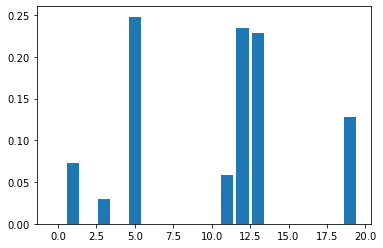

In [224]:
plt.bar(np.arange(20), dat['doc_topic_dists'][1])